# Structured guess at a profile for fdot_astro
This notebook is an attempt to use LDC injected data (originally derived from simulated catalogs of compact binaries) to hazard a "good enough for now" guess as to the tail of the distribution of compact binary fdot_astro

I assume in developing this profile, that most binaries are detached, and therefore have fdot_astro=0. The desire here is to create a distribution which is sharply peaked at fdot_astro=0, but has a tail shape that encodes our expectations about how fdot_astro is distributed among binaries which do not have fdot_astro=0.

## Utility functions
We're going to start by borrowing from functions from gbmcmc to calculate things, and to modify columns.

In [39]:
import numpy as np


# Adapted from GalacticBinaryWaveform.c
TSUN = 4.9255e-6
M_PI = 3.14159265358979323846
CLIGHT = 299792458.
PC = 3.0856775815e16

def galactic_binary_Mc(f, fd):
    pi83 = 21.170591578193 #pow(pi,8./3.)
    return ((fd/(96./5.)/pi83/(f**(11.0/3.0))) ** (3.0/5.0) )/TSUN

def galactic_binary_dL(f, fd, amp):
    return ((5./48.)*(fd/(M_PI*M_PI*f*f*f*amp))*CLIGHT/PC); #seconds  !check notes on 02/28!

def galactic_binary_fdot(Mc, f):
    M = Mc*TSUN
    Q = 19.2 # 96./5.
    return Q*(((M_PI**8)*(M**5)*(f**11))**(1./3.)); 


def concat_column(recarray, column_values, column_dtype):
    old_shape = recarray.shape
    old_dtype = recarray.dtype
    new_dt = np.dtype(old_dtype.descr + [column_dtype])

    new_recarray = np.zeros(old_shape, dtype = new_dt)
    for param_name, _ in old_dtype.descr:
            new_recarray[param_name] = recarray[param_name]
    new_recarray[column_dtype[0]] = column_values
    return new_recarray

def concat_dfdtastro(recarray):
    dfdtastro_value = recarray["dfdt"] - galactic_binary_fdot(recarray["mc"], recarray["f0"])
    return concat_column(recarray, dfdtastro_value, ('dfdtastro', '<f8'))

## Load LDC data
This will load either radler or sangria full datasets and extract interacting galactic binaries

In [40]:
import h5py
import matplotlib.pyplot as plt

f = h5py.File("/home/mtauraso/src/LDC-data/LDC1-4_GB_v2.hdf5", 'r')
radler = True

#f = h5py.File("/home/mtauraso/src/LDC-data/LDC2_sangria_training_v2.h5", 'r')
#radler = False

if(radler):
    sources = f['H5LISA']['GWSources']['GalBinaries']
    all_dfdt = sources['FrequencyDerivative'][:]

# for Radler all binaries are mixed together, so we have to ID the detached ones
    mask_detached = np.greater_equal(all_dfdt, 0.0)

    interacting_f0 = np.ma.masked_array(sources['Frequency'], mask = mask_detached).compressed()
    interacting_dfdt = np.ma.masked_array(sources['FrequencyDerivative'], mask = mask_detached).compressed()
    interacting_amp =  np.ma.masked_array(sources['Amplitude'][:], mask=mask_detached).compressed()
    num_dgb = np.count_nonzero(mask_detached)
    num_igb = len(mask_detached) - num_dgb

else:
    sources = f['sky']['igb']['cat']
    
    interacting_f0 = sources['Frequency']
    interacting_dfdt = sources['FrequencyDerivative']
    interacting_amp =  sources['Amplitude']
    num_dgb = len(f['sky']['dgb']['cat'])
    num_igb = len(f['sky']['igb']['cat'])



max_f0, min_f0 = (np.max(interacting_f0), np.min(interacting_f0))


In [18]:
print(num_dgb)
print(num_igb)

26433149
3424501


## Guess at the mass
LDC catalog doesn't have chirp masses for these sources, so we graph them next to some curves of fdot_gr for constant mass.
Particlarly in the plot of f0/dfdt one can see two branches with ~0.15 Msun and ~0.5 Msun in sangria data. We split the difference at 0.325 Msun below.

This is definitely an eyeball-fit and could be improved with actual mass data from simulated catalogs.

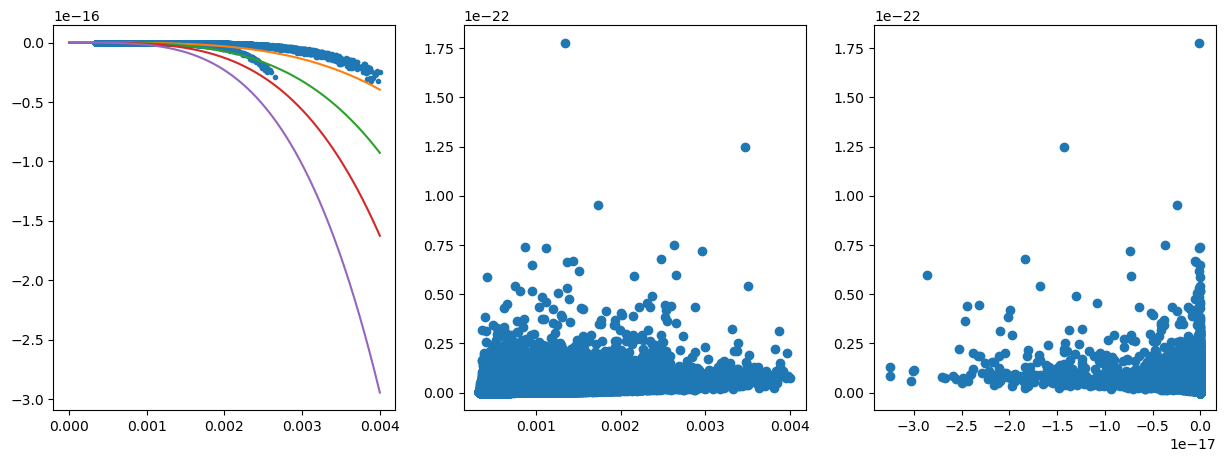

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(15,5)

min_f0 = 0
max_f0 = 0.004

clip_mask = np.logical_or(np.greater(interacting_f0, max_f0), np.less(interacting_f0, min_f0))

interacting_f0_clip = np.ma.masked_array(interacting_f0, mask = clip_mask).compressed()
interacting_dfdt_clip = np.ma.masked_array(interacting_dfdt, mask = clip_mask).compressed()
interacting_amp_clip = np.ma.masked_array(interacting_amp, mask = clip_mask).compressed()

ax1.plot(interacting_f0_clip, interacting_dfdt_clip, ls=None, lw=0.0, marker=".")
            #bins=(100,100), 
            #range=((0,0.008),(fdot_min, fdot_max))
            #)
f = np.linspace(min_f0, max_f0, 500)
ax1.plot(f, -galactic_binary_fdot(0.15, f))
ax1.plot(f, -galactic_binary_fdot(0.25, f))
ax1.plot(f, -galactic_binary_fdot(0.35, f))
ax1.plot(f, -galactic_binary_fdot(0.5, f))



ax2.scatter(interacting_f0_clip, interacting_amp_clip)
ax3.scatter(interacting_dfdt_clip, interacting_amp_clip)
plt.show()

## Calculate distribution of fdot_astro

In this we're fitting a $\frac{1}{x^2 + a^2}$ profile to the calculated distribution of fdot_astro. This is another eyeball fit where the a value ends up being `DFDTASTRO_A` in `GalacticBinaryPrior.c`. 

What is notable about this function is that it fits the distribution of sources at multiple orders of magnitude for fdot_astro. The same cannot be said of several power-law curves attempted.

Note that in the plots below, all figures on the same column share a bucket width, with 1.0 in any bucket representing the total amount of detached galactic binaries in the LDC sample.

The idea behind this unit choice is that for some bucketing of the density function, where the bucket centered at 0.0 does not contain any interacting binaries, essentially all of the detached binaries should be in the single bucket around 0.0. Therefore the level of that bucket ought to be ~1.0 in this unit system.

If the central bucket is not near 1.0 I would argue that we're allowing the probability density to grow too fast or too slow as it approaches zero. Even though the shape of the tail may fit the interacting binaries in the catalog, there will not be the right amount of support to find interacting binaries.

In the plots below, the bucket near 0.0 is 1e-20 Hz^2 wide, and is wide enough that the very next bucket contains interacting binaries. The probability desity derived here shows that bucket containing ~60% of the detached binaries.

-1.674968949986377e-20 -6.448045302677689e-15
3424501


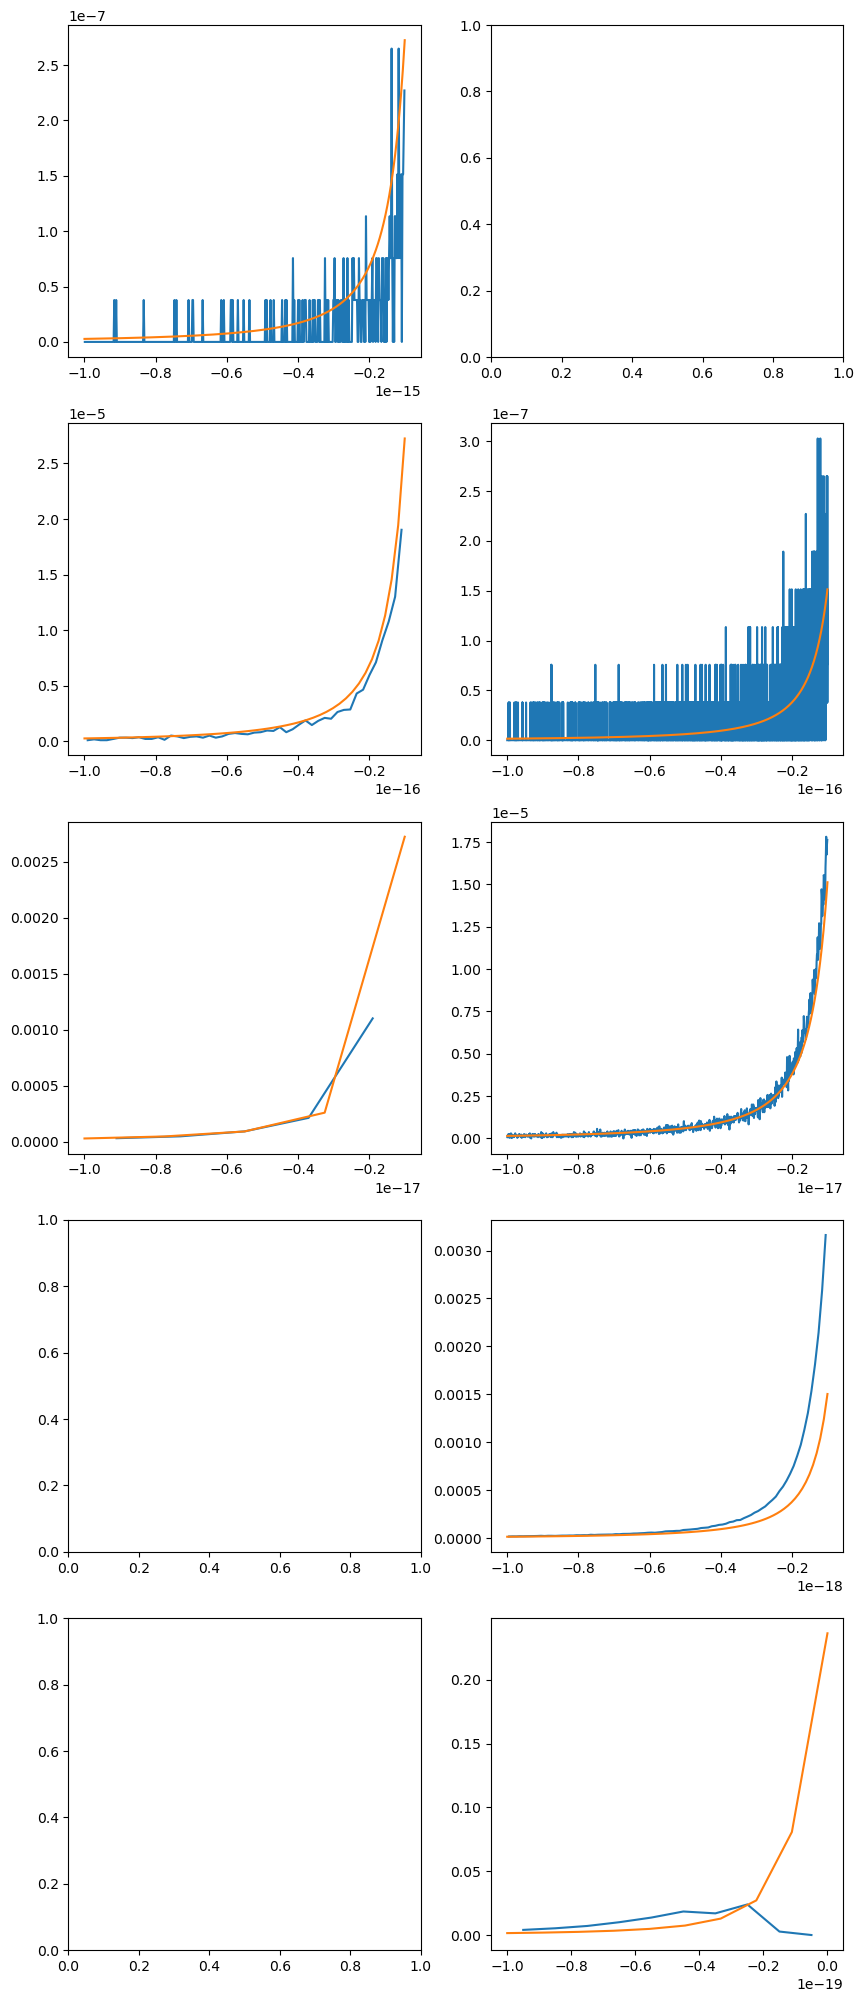

In [43]:
# OK so if I assume a chirp mass of 0.325 M_sun for these then what do I get for fdot_astro (and also what do I just get for fdot regardless)

mc_guess = 0.325
fdot_range =(-1e-16,-1e-17)
fdot_bins = 200

#calc fdot astro
dfdt_astro = interacting_dfdt - galactic_binary_fdot(mc_guess, interacting_f0) 

# Constant for our 1/(x^2+a^2) probability distribution
#a = 5e-21
a = 8e-21

def profile_function(x, dbin):
    #norm_factor = (1/a)*(np.arctan(fdotastromax*1e-17/a) - np.arctan(fdotastromin*1e-17/a))
    scale = 4e-14/num_dgb
    return (dbin)*(scale)*(1/(x**2 + a**2))

'''
def profile_function(x, dbin):
    a = 1e-20
    scale = 1e25
    return (dbin)*(scale)*np.exp(-abs(x)/a)
    #return(-abs(x)/a)
'''
def plot_fit(ax, fdot_range, fdot_bins, verbose = False):
    vals, bins = np.histogram(dfdt_astro, bins=fdot_bins, range=fdot_range)
    dbin = bins[1]-bins[0]
    bin_centers = (bins[:-1] + bins[1:])/2

    ax.plot(bin_centers, vals/num_dgb)
    #ax.hist(dfdt_astro, bins=fdot_bins, range=fdot_range, log=False)

    x = np.linspace(fdot_range[0], fdot_range[1], fdot_bins)
    if(verbose): print(x)
    ax.plot(x, profile_function(x, dbin))
    if(verbose): print(profile_function(x,dbin))


# histogram fdot astro
fig,ax = plt.subplots(5,2)
fig.set_size_inches(10,25)

plot_fit(ax[0][0], (-1e-15, -1e-16), 500)
plot_fit(ax[1][0], (-1e-16, -1e-17), 50)
plot_fit(ax[2][0], (-1e-17, -1e-18), 5)


plot_fit(ax[1][1], (-1e-16, -1e-17), 9000)
plot_fit(ax[2][1], (-1e-17, -1e-18), 900)
plot_fit(ax[3][1], (-1e-18, -1e-19), 90)
plot_fit(ax[4][1], (-1e-19, 0.0), 10)

#fig.show()

print(max(dfdt_astro), min(dfdt_astro))
print(len(dfdt_astro))
#c = 4.86e17
#scale = 1000
#y = scale * np.exp(-np.abs(x)*c)

#y = 10*10**(10**(-np.abs(x)*1e17))

#y = 8.94*((1e-17)**2/(abs(x)**2))

#print(8.94e-34/dbin)

#a = 1e-17




## Calculating the area under 1/(x^2+a^2)
This is basically a sanity check and sandbox for `dfdt_astro_prior_norm` in `GalacticBinaryPrior.c`

When the prior is used in code, we need to normalize it so it can be combined with other probabilities in a reasonable manner.
We first generate the needed limits on dfdt's old uniform prior given a frequency range, mirroring a calculation in `set_uniform_prior` in `GalacticBinaryPrior.c`

Then we calculate the area under the new profile function.

In [5]:
freq_min = 3.9936/1000 #Hz
freq_max = 4.0018/1000 #Hz
mc_min = 0.15 #Msun
mc_max = 1.0 #Msun

fdotgr_min = galactic_binary_fdot(mc_min, freq_min)*1e17
fdotgr_max = galactic_binary_fdot(mc_max, freq_max)*1e17

print(fdotgr_min, fdotgr_max)

fdot_min = -0.000005*(freq_min**(13./3.))*1e17
fdot_max = 0.0000008*(freq_max**(11./3.))*1e17

print(fdot_min, fdot_max)

# fdotastro = fdot - fdotgr
# fdotgr is always positive
# If we believe the bounds on fdot, then the lowest fdotastro could be is
fdotastromin = (fdot_min - fdotgr_max)

# And the highest it could be is
fdotastromax = (fdot_max - fdotgr_min)
print(fdotastromin, fdotastromax)


#fdot = fdotgr + fdotastro
#fdotgr always positive
# if we believe the bounds on fdotgr, and want to set fdotastro such that
# the original fdot range is all reachable then we need
fdotastromin = fdot_min - fdotgr_min
fdotastromax = fdot_max - fdotgr_max

print(fdotastromin, fdotastromax)

3.9349594392527076 93.6241356244883
-20.17823211672091 129.22891952751561
-113.80236774120921 125.2939600882629
-24.113191555973618 35.60478390302731


6.283115749990131e+20
47.88956785585845


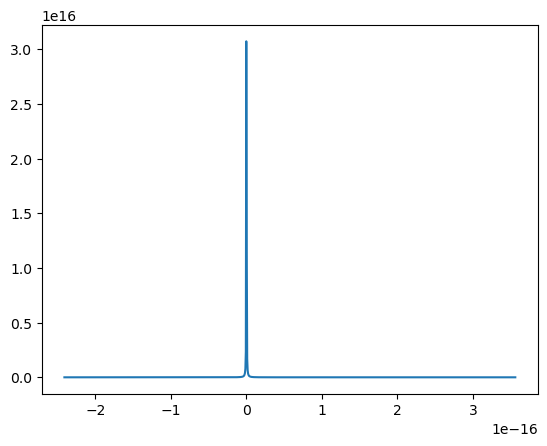

In [40]:
import matplotlib.pyplot as plt

x = np.linspace(fdotastromin*1e-17, fdotastromax*1e-17, 1000)

# Int( 1/(x**2 + a**2), x, fdotmin, fdotmax) = 
norm_factor = (1/a)*(np.arctan(fdotastromax*1e-17/a) - np.arctan(fdotastromin*1e-17/a))
print(norm_factor)
print(np.log(norm_factor))

y = (1/norm_factor)* (1/(x**2 + (a)**2))
plt.plot(x,y)

#1e17*(np.arctan(-24) - np.arctan(32))

In [37]:
data_t = 15728640
a = 5e-21
dfdt_max = fdotastromax*data_t*data_t*1e-17
dfdt_min = fdotastromin*data_t*data_t*1e-17

print(fdotastromax*1e-17, fdotastromin*1e-17)
print(dfdt_max, dfdt_min)

rng = np.random.default_rng()

def dfdtastro_norm(max, min):
    a_ = a*data_t*data_t
    return -np.log(a_) + np.log(np.arctan(max/a_) - np.arctan(min/a_))

def evaluate_dfdtastro_prior(dfdtastro):
    a_ = a*data_t*data_t
    a_sq = a_*a_
    dfdt_sq = dfdtastro*dfdtastro
    return - dfdtastro_norm(dfdt_max, dfdt_min) - np.log(dfdt_sq + a_sq)

def uniform_density():
    return np.log(dfdt_max - dfdt_min)

def draw_dfdt_astro_uniform1():
    drawn_dfdt = dfdt_min + rng.random()*(dfdt_max - dfdt_min)
    density = evaluate_dfdtastro_prior(drawn_dfdt)
    return (drawn_dfdt, density)

def draw_dfdt_astro_uniform2():
    drawn_dfdt = dfdt_min + rng.random()*(dfdt_max - dfdt_min)
    density = np.log(dfdt_max - dfdt_min)
    return (drawn_dfdt, density)



print(draw_dfdt_astro_uniform1())

print(evaluate_dfdtastro_prior(0.0))
print(-uniform_density())
print(evaluate_dfdtastro_prior(5e-17*data_t*data_t))

print(np.exp(dfdtastro_norm(1e-20*data_t*data_t, -1e-20*data_t*data_t))/np.exp(dfdtastro_norm(dfdt_max, dfdt_min)))



3.5604783903027314e-16 -2.411319155597362e-16
0.08808271628811815 -0.05965365262181187
(-0.009433891124618045, -5.420686978586112)
12.458142600421032
1.9123258847527542
-5.962538153531332
0.70484056754538
